# 高野「開発経済学」第3章の弱い操作変数の数値例の解説

教科書の脚注66にある通り、真のデータ生成過程は以下の通りであるとする。

\begin{align*}
  y_i &= x_i + 2 (\theta q_i + (1 - \theta) \eta_i) \\
  x_i &= \pi z_i + 2 (\theta q_i + (1 - \theta) \nu_i) \\
\end{align*}

ここで、$q_i, \eta_i, \nu_i$ は互いに独立で平均0、分散1の正規分布に従う確率変数であり、$z_i$ は平均0、分散1の正規分布に従う外生変数である。

均一分散なので、$\pi$ の推定量、$\widehat{\pi}$ の漸近分布は次のように与えられる（回帰の際には切片を含めないとする）。

$$
  \sqrt{n}(\widehat{\pi} - \pi) 
  \xrightarrow{d} N\left(0, \frac{\mathrm{Var} \left( 2 \left( \theta q_i + (1 - \theta) \nu_i \right) \right)}{\mathrm{Var}(z_i)}  \right) 
  = N\left(0,  4 \left( \theta^2 + (1 - \theta)^2 \right)  \right) 
$$

最後の等号では$q_i$と$\nu_i$が独立であること、これらの分散が1であること、および$z_i$の分散が1であることを用いた。

なので、$n$が大きいとき、$\pi=0$という帰無仮説のもとで、$\widehat{\pi}$の$t$推定量は次のように近似される。

$$
  t_{\widehat{\pi}} 
  = \frac{\widehat{\pi} }{\mathrm{se}(\widehat{\pi})} 
  \approx \frac{\sqrt{n} \pi}{2 \sqrt{\theta^2 + (1 - \theta)^2}} 
$$

これより、ある$t_{\widehat{\pi}}$のもとで、$\pi$の大きさは次のように与えられる。
$$
  \pi = \frac{2 \sqrt{\theta^2 + (1 - \theta)^2}}{\sqrt{n}} t_{\widehat{\pi}}
$$

例えば、$\theta = 0.5$、$n=1000$、$t_{\widehat{\pi}} = 2$の場合、$\pi = \frac{1}{10 \sqrt{5}} \times 2$となり、脚注66の数値例と一致する。

教科書の脚注67にある通り、$\theta$は内生性の度合いを表す$\rho \equiv \mathrm{Corr}(x_i, \varepsilon_i | z_i)$と対応している。(これ$z_i$で条件付ける必要あるかな…？)
ここで、$\varepsilon_i$は$y_i$と$x_i$の回帰における誤差項である： $\varepsilon_i = 2 \left(  \theta q_i + (1 - \theta) \eta_i \right)$.

$\rho$は次のように計算される。

\begin{align*}
  \rho 
  &= \frac{\mathrm{Cov}(x_i, \varepsilon_i | z_i)}{\sqrt{\mathrm{Var}(x_i | z_i)} \sqrt{\mathrm{Var}(\varepsilon_i | z_i)}} \\
  &= \frac{\mathrm{Cov} \left( 2 \left( \theta q_i + (1 - \theta) \nu_i \right), 2 \left(  \theta q_i + (1 - \theta) \eta_i \right) \right)}{\sqrt{\mathrm{Var} \left( 2 \left( \theta q_i + (1 - \theta) \nu_i \right) \right)} \sqrt{\mathrm{Var} \left( 2 \left(  \theta q_i + (1 - \theta) \eta_i \right) \right)}} \\
  &= \frac{4 \theta^2}{\sqrt{4 (\theta^2 + (1 - \theta)^2)} \sqrt{4 (\theta^2 + (1 - \theta)^2)}} \\
  &= \frac{\theta^2}{\theta^2 + (1 - \theta)^2}
\end{align*}

これは$\theta = \frac{\sqrt{\rho}}{\sqrt{1 - \rho} + \sqrt{\rho}}$と変形でき、$\rho$が0.5のとき、$\theta = \frac{\sqrt{0.5}}{\sqrt{0.5} + \sqrt{0.5}} = .5$となり、$\rho$が0.8のときは $\theta = \frac{\sqrt{0.8}}{\sqrt{0.2} + \sqrt{0.8}} = 2 / 3$となるので、どちらも脚注67の数値例と一致する。

## シミュレーションコード

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.iv.model import IV2SLS

In [128]:
N = 1_000
sim_N = 10_000

In [ ]:
def simulate_iv(rho, t, dim_z=1, N=N, sim_N=sim_N):

    theta = np.sqrt(rho) / (np.sqrt(1 - rho) + np.sqrt(rho))
    pi = t * 2 * np.sqrt(1 - 2 * theta + 2 * theta ** 2) / np.sqrt(N)

    coef_store = np.array([])
    tval_store = np.array([])

    for sim in range(sim_N):
        np.random.seed(sim)

        q = np.random.normal(size=N)
        eta = np.random.normal(size=N)
        z = np.random.normal(size=(N, dim_z))
        nu = np.random.normal(size=N)

        x = pi * z[:, 0] + 2 * (theta * q + (1 - theta) * nu)
        y = x + 2 * (theta * q + (1 - theta) * eta)

        res = IV2SLS(y, None, x, z).fit()

        coef_store = np.append(coef_store, res.params.iloc[0])
        tval_store = np.append(tval_store, (res.params.iloc[0] - 1) / res.std_errors.iloc[0])
    
    return coef_store, tval_store

In [202]:
rho = .5
t = 4
coef_store, tval_store = simulate_iv(rho, t)

In [203]:
(np.abs(tval_store) > 1.96).mean()

np.float64(0.0425)

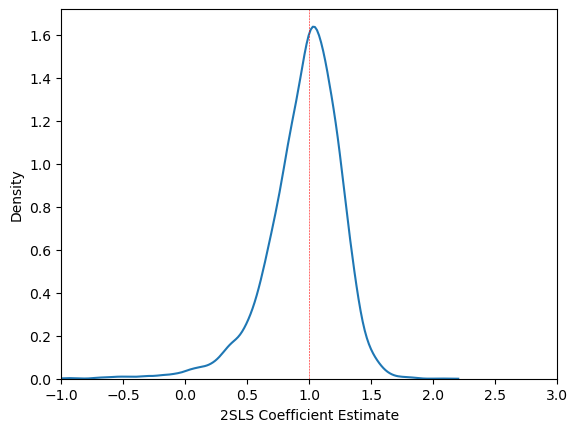

In [204]:
sns.kdeplot(coef_store[(coef_store > -1) & (coef_store < 3)])
plt.xlim(-1, 3)
plt.xlabel("2SLS Coefficient Estimate")
plt.axvline(1, color='red', linestyle='--', linewidth=.4)

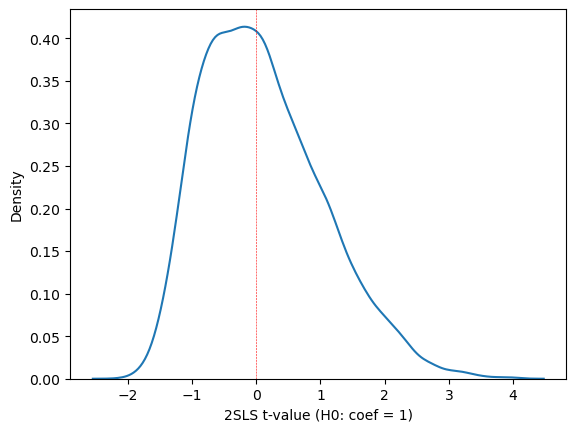

In [205]:
sns.kdeplot(tval_store)
plt.xlabel("2SLS t-value (H0: coef = 1)")
plt.axvline(0, color='red', linestyle='--', linewidth=.4)